In [29]:
#necessary packages
import os
!pip install pytesseract
!apt-get install tesseract-ocr
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import pytesseract as pt
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet
from glob import glob
from skimage import io
from shutil import copy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2build2).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [2]:
#linking my google drive to my code
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#checking out the path of my data if it is not null
data_path = '/content/drive/MyDrive/images/'
folder_path = (data_path)
file_pattern = folder_path + '*.xml'
path = glob(file_pattern)
print(path)

['/content/drive/MyDrive/images/Cars0.xml', '/content/drive/MyDrive/images/Cars1.xml', '/content/drive/MyDrive/images/Cars103.xml', '/content/drive/MyDrive/images/Cars105.xml', '/content/drive/MyDrive/images/Cars107.xml', '/content/drive/MyDrive/images/Cars102.xml', '/content/drive/MyDrive/images/Cars106.xml', '/content/drive/MyDrive/images/Cars101.xml', '/content/drive/MyDrive/images/Cars100.xml', '/content/drive/MyDrive/images/Cars10.xml', '/content/drive/MyDrive/images/Cars104.xml', '/content/drive/MyDrive/images/Cars247.xml', '/content/drive/MyDrive/images/Cars354.xml', '/content/drive/MyDrive/images/Cars223.xml', '/content/drive/MyDrive/images/Cars403.xml', '/content/drive/MyDrive/images/Cars420.xml', '/content/drive/MyDrive/images/Cars270.xml', '/content/drive/MyDrive/images/Cars336.xml', '/content/drive/MyDrive/images/Cars195.xml', '/content/drive/MyDrive/images/Cars130.xml', '/content/drive/MyDrive/images/Cars261.xml', '/content/drive/MyDrive/images/Cars125.xml', '/content/driv

In [4]:
#creating labels from the train images
folder_path = (data_path)
file_pattern = folder_path + '*.xml'
path = glob(file_pattern)

labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
for filename in path:

    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

In [5]:
#checking if the data was imported correctly
df = pd.DataFrame(labels_dict)
df.to_csv('labels.csv',index=False)
df.head()

,filepath,xmin,xmax,ymin,ymax
0,/content/drive/MyDrive/images/Cars0.xml,226,419,125,173
1,/content/drive/MyDrive/images/Cars1.xml,134,262,128,160
2,/content/drive/MyDrive/images/Cars103.xml,230,248,129,134
3,/content/drive/MyDrive/images/Cars105.xml,152,206,147,159
4,/content/drive/MyDrive/images/Cars107.xml,141,311,113,164


In [6]:
#checcking if the folder path has images
folder_path = r'/content/drive/MyDrive/images'
file_pattern = os.path.join(folder_path, '*.xml')

path = glob(file_pattern)

def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join(folder_path, filename_image)
    return filepath_image

filename = df['filepath'][0]
result = getFilename(filename)
print(result)

/content/drive/MyDrive/images/Cars0.png


In [7]:
#randomly checking the file path
image_path = list(df['filepath'].apply(getFilename))
image_path[:10]#random check

['/content/drive/MyDrive/images/Cars0.png',
 '/content/drive/MyDrive/images/Cars1.png',
 '/content/drive/MyDrive/images/Cars103.png',
 '/content/drive/MyDrive/images/Cars105.png',
 '/content/drive/MyDrive/images/Cars107.png',
 '/content/drive/MyDrive/images/Cars102.png',
 '/content/drive/MyDrive/images/Cars106.png',
 '/content/drive/MyDrive/images/Cars101.png',
 '/content/drive/MyDrive/images/Cars100.png',
 '/content/drive/MyDrive/images/Cars10.png']


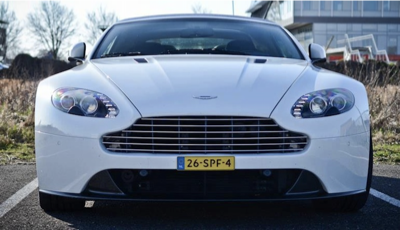

In [8]:
#testing the images
file_path = image_path[87] #path of our image N2.jpeg
img = cv2.imread(file_path) #read the image
# xmin-1804/ymin-1734/xmax-2493/ymax-1882
img = io.imread(file_path) #Read the image
fig = px.imshow(img)
fig.update_layout(width=600, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 8 - N2.jpeg with bounding box')
fig.add_shape(type='rect',x0=243, x1=253, y0=189, y1=500, xref='x', yref='y',line_color='cyan')

In [9]:
#Targeting all our values in array selecting all columns
labels = df.iloc[:,1:].values
data = []
output = []
for ind in range(len(image_path)):
    image = image_path[ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    # Prepprocesing
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 # Normalization
    # Normalization to labels
    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # Normalized output
    # Append
    data.append(norm_load_image_arr)
    output.append(label_norm)

In [10]:
# Convert data to array
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

In [11]:
# Split the data into training and testing set using sklearn.
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((346, 224, 224, 3), (87, 224, 224, 3), (346, 4), (87, 4))

In [12]:
#using inception_resnet
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False, input_tensor=Input(shape=(224,224,3)))
# ---------------------
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation="relu")(headmodel)
headmodel = Dense(250,activation="relu")(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)


# ---------- model
model = Model(inputs=inception_resnet.input,outputs=headmodel)

219055592/219055592 [==============================] - 11s 0us/step


In [13]:
# Complie model
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [14]:
#fitting in of the pretrained model into our data
tfb = TensorBoard('object_detection')
history = model.fit(x=x_train,y=y_train,batch_size=10,epochs=180,
                    validation_data=(x_test,y_test),callbacks=[tfb])

Epoch 1/180
35/35 [==============================] - 137s 485ms/step - loss: 0.0365 - val_loss: 0.0315
Epoch 2/180
35/35 [==============================] - 8s 231ms/step - loss: 0.0126 - val_loss: 0.0188
Epoch 3/180
35/35 [==============================] - 8s 235ms/step - loss: 0.0080 - val_loss: 0.0165
Epoch 4/180
35/35 [==============================] - 8s 238ms/step - loss: 0.0061 - val_loss: 0.0237
Epoch 5/180
35/35 [==============================] - 8s 236ms/step - loss: 0.0047 - val_loss: 0.0185
Epoch 6/180
35/35 [==============================] - 8s 238ms/step - loss: 0.0042 - val_loss: 0.0172
Epoch 7/180
35/35 [==============================] - 8s 236ms/step - loss: 0.0033 - val_loss: 0.0263
Epoch 8/180
35/35 [==============================] - 8s 235ms/step - loss: 0.0031 - val_loss: 0.0202
Epoch 9/180
35/35 [==============================] - 8s 235ms/step - loss: 0.0023 - val_loss: 0.0187
Epoch 10/180
35/35 [==============================] - 8s 230ms/step - loss: 0.0021 - val_

In [15]:
#save the model
model.save('./object_detection.h5')

In [16]:
# Load model
model = tf.keras.models.load_model('/content/drive/MyDrive/object_detection.h5')
print('Model loaded Sucessfully')

Model loaded Sucessfully


In [18]:
#loading our test picture and changing it to the right format
path = '/content/drive/MyDrive/ttest/Cars6.png'
image = load_img(path) # PIL object
image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
image1 = load_img(path,target_size=(224,224))
image_arr_224 = img_to_array(image1)/255.0  # Convert into array and get the normalized output

# Size of the orginal image
h,w,d = image.shape
print('Height of the image =',h)
print('Width of the image =',w)

Height of the image = 375
Width of the image = 500



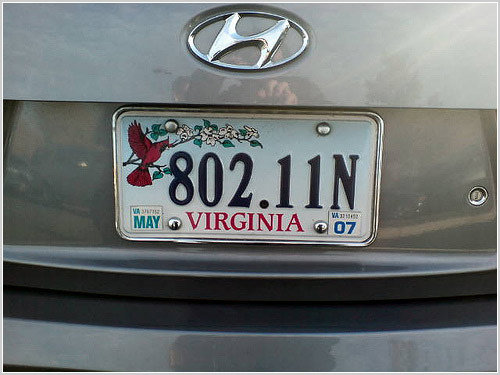

In [19]:
#Output of our test image
fig = px.imshow(image)
fig.update_layout(width=700, height=500,  margin=dict(l=10, r=10, b=10, t=10), xaxis_title='Figure 13 - TEST Image')

In [20]:
#shape of the edited image
image_arr_224.shape

(224, 224, 3)

In [21]:
#passing just one image
test_arr = image_arr_224.reshape(1,224,224,3)
test_arr.shape

(1, 224, 224, 3)

In [22]:
# Make predictions on the edited image
coords = model.predict(test_arr)
coords

1/1 [==============================] - 6s 6s/step


array([[0.24189569, 0.7387129 , 0.3674189 , 0.6010671 ]], dtype=float32)

In [23]:
# Denormalize the values convert back into our original form values
denorm = np.array([w,w,h,h])
coords = coords * denorm
coords

array([[120.94784528, 369.35645342, 137.78208196, 225.40017217]])

In [24]:
#converting the denormalised value to int
coords = coords.astype(np.int32)
coords

array([[120, 369, 137, 225]], dtype=int32)

In [25]:
# Draw bounding on top the image
xmin, xmax,ymin,ymax = coords[0]
pt1 =(xmin,ymin)
pt2 =(xmax,ymax)
print(pt1, pt2)

(120, 137) (369, 225)



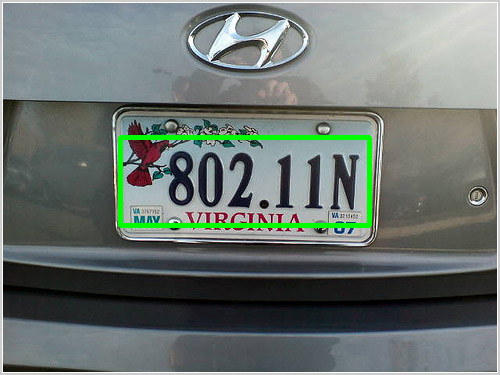

In [26]:
#printing of the image with the bouding
cv2.rectangle(image,pt1,pt2,(0,255,0),3)
fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10))


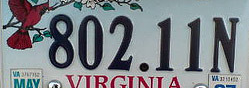

In [27]:
#extracting plate number from the image using tessaract and first step is identifying area of interest
img = np.array(load_img(path))
xmin ,xmax,ymin,ymax = coords[0]
roi = img[ymin:ymax,xmin:xmax]
fig = px.imshow(roi)
fig.update_layout(width=350, height=250, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 15 Cropped image')

In [31]:
# pytesseract.pytesseract.tesseract_cmd = "/opt/homebrew/Cellar/tesseract/"
#reading the test on the plate number
import pytesseract
custom_config = r'--oem 3 --psm 6'

img = cv2.imread('/content/drive/MyDrive/ttest/Cars6.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


text_extract = pytesseract.image_to_string(img, config=custom_config)

In [32]:
# extract text from image
text = pt.image_to_string(roi)
print(text)

#802 LIN

